In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import copy
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, BoundaryNorm

In [18]:
class Gray_Scott:
    def __init__(self, Nx, Ny, dx, dt, T_max, f, k, Du, Dv, size_of_square, max_initial_v):
        self.Nx = Nx
        self.Ny = Ny
        self.dx = dx
        self.dt = dt
        self.T_max = T_max
        self.f = f
        self.k = k
        self.Du = Du
        self.Dv = Dv
        self.size_of_square = size_of_square
        self.max_initial_v = max_initial_v
        self.u = np.full((Nx, Ny), 0.5)
        self.u_initial = copy.deepcopy(self.u)
        self.v = np.zeros((Nx, Ny))
        for i in range(int(self.Nx / 2) - self.size_of_square, int(self.Nx / 2) + self.size_of_square):
            for j in range(int(self.Ny / 2) - self.size_of_square, int(self.Ny / 2) + self.size_of_square):
                self.v[i][j] = self.max_initial_v
        self.v_initial = copy.deepcopy(self.v)
        self.timesteps = range(0, self.T_max, self.dt)

    def initial_concentrations(self):
        return self.u_initial, self.v_initial

    def finite_differencing(self, row, col):
        """
        Function that implements the finite differencing approximation, at every given node.

        :param row: Refers to the row of the computational grid.
        :param col: Refers to the column of the computational grid.
        :return: The function returns the update computational grid, after the finite differencing step
        """
        u_not_updated = copy.deepcopy(self.u)
        u_updated = self.u[row][col] + ((self.dt * self.Du / (self.dx ** 2)) * (self.u[row + 1][col] +
                                                                                self.u[row - 1][col] +
                                                                                self.u[row][(col + 1) % self.Ny] +
                                                                                self.u[row][col - 1] - 4 * self.u[row][
                                                                                    col])) - (self.u[row][col]) * (
                                (self.v[row][col]) ** 2) + self.f * (1 - self.u[row][col])

        v_updated = self.v[row][col] + ((self.dt * self.Dv / (self.dx ** 2)) * (self.v[row + 1][col] +
                                                                                self.v[row - 1][col] +
                                                                                self.v[row][(col + 1) % self.Ny] +
                                                                                self.v[row][col - 1] - 4 * self.v[row][
                                                                                    col])) + (
                    u_not_updated[row][col]) * ((self.v[row][col]) ** 2) - (self.f + self.k) * self.v[row][col]
        return v_updated, u_updated

    def time_dependent_diffusion(self, noise_fraction, progress=True, add_noise=False):
        v_t_dict = {'v(t = 0)': self.v_initial}
        u_t_dict = {'u(t = 0)': self.u_initial}
        if progress:
            pbar = tqdm(total=self.T_max, position=0, leave=True)

        for timestep in self.timesteps:
            v_t_array = np.zeros((self.Nx, self.Ny))
            u_t_array = np.zeros((self.Nx, self.Ny))
            # all horizontal lines of the grid
            for j in range(1, self.Nx - 1):
                # all vertical lines of the grid
                for i in range(self.Ny):
                    # do the finite differencing and append the updated v value at the current node
                    v_t_array[j][i] = self.finite_differencing(j, i)[0]
                    u_t_array[j][i] = self.finite_differencing(j, i)[1]
                    # periodic boundary conditions
                    if  i == 0:
                        v_t_array[j][0] = v_t_array[j][self.Ny-1]
                        u_t_array[j][0] = u_t_array[j][self.Ny-1]

            if add_noise:
                # add noise
                noise_scale = noise_fraction * self.max_initial_v  # 5% of max concentration
                noise = np.random.normal(scale=noise_scale, size=(self.Nx, self.Ny))
                v_t_array = v_t_array + noise

            self.v = v_t_array
            self.u = u_t_array
            v_t_dict[f'v(t = {timestep + 1})'] = v_t_array
            u_t_dict[f'u(t = {timestep + 1})'] = u_t_array

            if progress:
                pbar.update()
        if progress:
            pbar.close()
            return v_t_dict, u_t_dict
        return v_t_dict, u_t_dict

    def plot_solution(self, v, t):
        plt.imshow(v, origin='lower', cmap='inferno')
        plt.colorbar()
        plt.clim(0, 0.4)
        plt.xticks(range(0, self.Nx, int(0.2 * self.Nx)))
        plt.yticks(range(0, self.Ny, int(0.2 * self.Ny)))
        plt.title(f'Gray-Scott diffusion for t = {t}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.savefig(f'downloads/grayscott_t={t}_boundary_U.png', dpi=300)
        plt.show()

    def plot_animation(self, solution_dict, animation_step):
        fig, ax = plt.subplots()
        im = ax.imshow(solution_dict['v(t = 0)'], cmap='inferno')

        # Define the update function for the animation
        def update(frame):
            solution_name = f'v(t = {frame + animation_step})'
            im.set_data(solution_dict[solution_name])
            ax.set_title(f'Concentration of {solution_name}')
            return [im]

        # Create the animation
        anim = FuncAnimation(fig, update, frames=len(solution_dict), interval=1000, repeat=True)
        plt.show()


gray_scott = Gray_Scott(Nx=101, Ny=101, dx=1, dt=1, T_max=8000, f=0.035, k=0.060, Du=0.16, Dv=0.08, size_of_square=10,
                        max_initial_v=0.25)
v_t_dict, u_t_dict = gray_scott.time_dependent_diffusion(noise_fraction=0.05, add_noise=False)
# v_f = v_t_dict[f'v(t = {gray_scott.T_max + 1 - gray_scott.dt})']
# gray_scott.plot_solution(v=v_f)

# for t in range(0,gray_scott.T_max + 1, 1000):
#     v_t = v_t_dict[f'v(t = {t})']
#     print(f't = {t}')
#     gray_scott.plot_solution(v=v_t)


# gray_scott.plot_animation(solution_dict=v_t_dict, animation_step=100)
     

100%|███████████████████████████████████████| 8000/8000 [31:00<00:00,  4.30it/s]


t = 1000


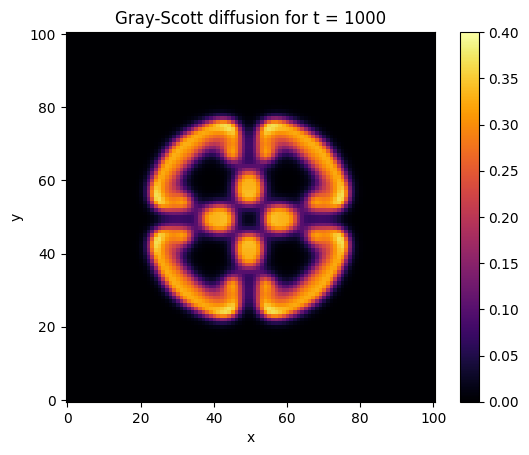

t = 1400


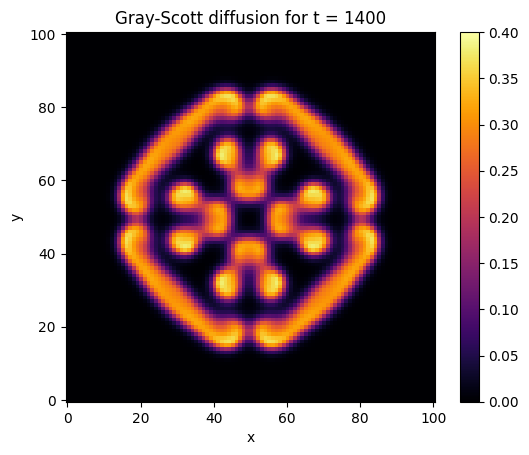

t = 2700


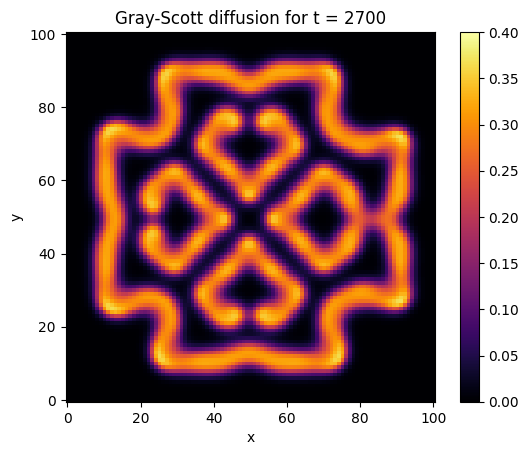

t = 4000


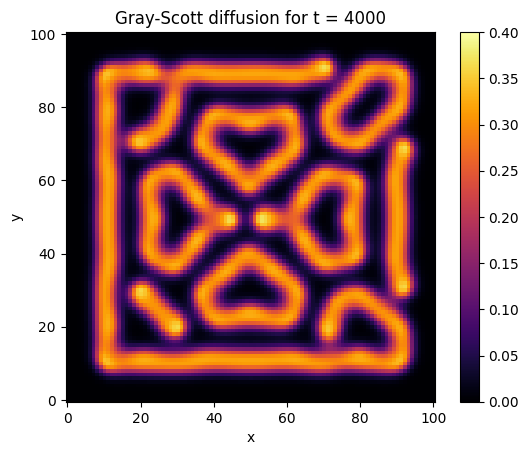

t = 6000


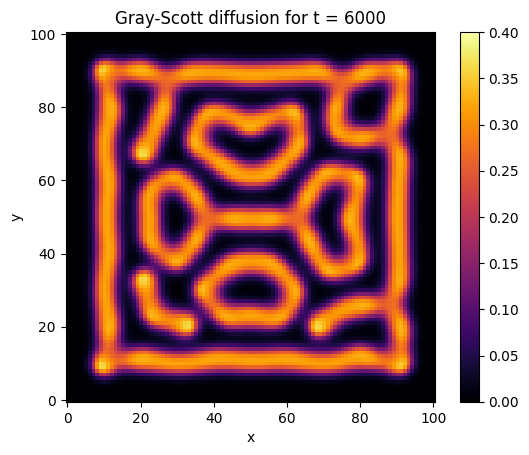

t = 8000


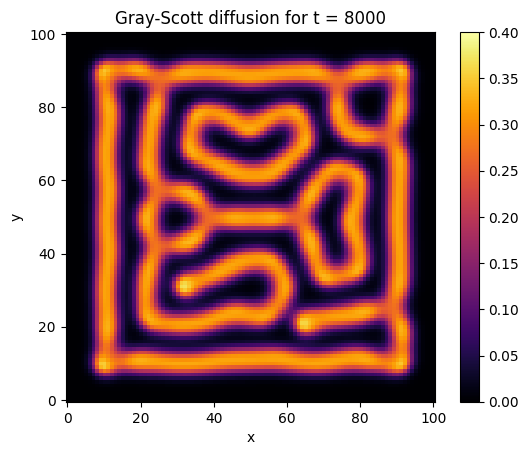

t = 1000


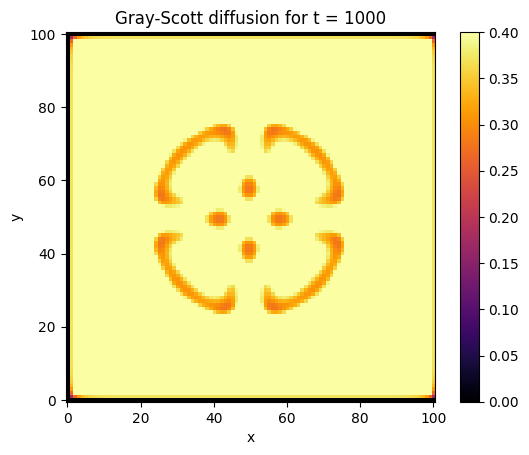

t = 1400


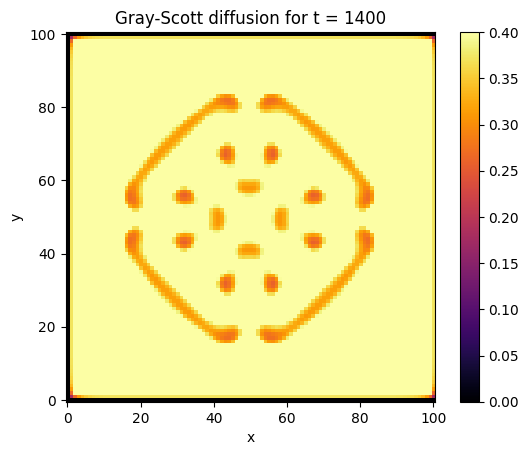

t = 2700


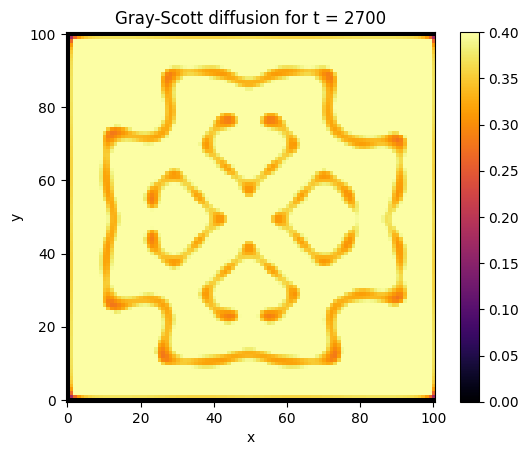

t = 4000


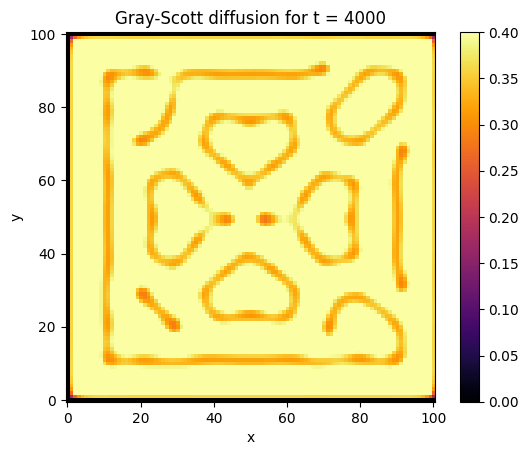

t = 6000


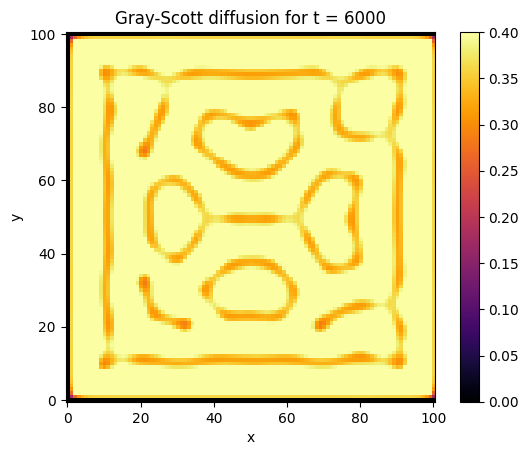

  2%|▍                              | 62/4000 [47:47:27<3035:30:15, 2774.97s/it]

t = 8000


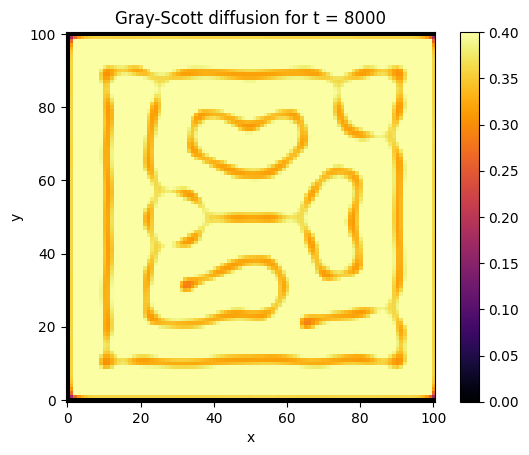

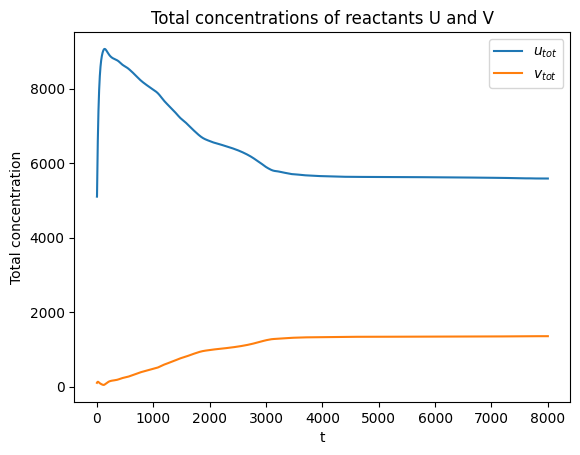

In [20]:
t_list = [1000, 1400, 2700, 4000, 6000, 8000]
for t in t_list:
    v_t = v_t_dict[f'v(t = {t})']
    print(f't = {t}')
    gray_scott.plot_solution(v=v_t, t=t)

for t in t_list:
    u_t = u_t_dict[f'u(t = {t})']
    print(f't = {t}')
    gray_scott.plot_solution(v=u_t, t=t)
    
u_tot = []
v_tot = []
t_list = range(gray_scott.T_max + 1)
for t in range(gray_scott.T_max + 1):
    u_t = u_t_dict[f'u(t = {t})']
    v_t = v_t_dict[f'v(t = {t})']
    u_tot_t = np.sum(u_t)
    v_tot_t = np.sum(v_t)
    u_tot.append(u_tot_t)
    v_tot.append(v_tot_t)

plt.plot(t_list, u_tot, label=r'$u_{tot}$')
plt.plot(t_list, v_tot, label=r'$v_{tot}$')
plt.xlabel('t')
plt.ylabel('Total concentration')
plt.title('Total concentrations of reactants U and V')
plt.legend()
plt.savefig(f'downloads/tot_u_v_{gray_scott.T_max}.png', dpi=300)
plt.show()

## Experiment with f and k to see what happens

In [63]:
f_list = [0.03, 0.04, 0.05, 0.06]
k_list = [0.03, 0.04, 0.05, 0.06]
# T_list = [10, 200]
T_list = [10, 5000]

tot_u_dict = {}
tot_v_dict = {}

for i, t in enumerate(T_list):
    plt.figure(figsize=(8, 6))
    max_concentrations = np.zeros((len(f_list), len(k_list)))
    tot_concentrations = np.zeros((len(f_list), len(k_list)))

    counter = 0
    for j, f_value in enumerate(f_list):
        for k, k_value in enumerate(k_list):
            counter += 1
            print(f'\n Completing run {counter}/{(len(f_list)*len(k_list))} for (f,k) for t = {t} ')

            gray_scott = Gray_Scott(Nx=101, Ny=101, dx=1, dt=1, T_max=t, f=f_value, k=k_value, Du=0.16,
                                    Dv=0.08, size_of_square=10, max_initial_v=0.25)
            if t >= 100:
                v_t_dict, u_t_dict = gray_scott.time_dependent_diffusion(noise_fraction=0.05, progress=True, add_noise=False)

            else:
                v_t_dict, u_t_dict = gray_scott.time_dependent_diffusion(noise_fraction=0.05, progress=False, add_noise=False)


            v_t = v_t_dict[f'v(t = {t})']
            if t == T_list[-1]:
                tot_conc_iter_v = []
                tot_conc_iter_u = []
                for iter in range(T_list[-1]):
                    v_iter = v_t_dict[f'v(t = {iter})']
                    u_iter = u_t_dict[f'u(t = {iter})']
                    tot_concentration_v_t = np.sum(v_iter.flatten())
                    tot_concentration_u_t = np.sum(u_iter.flatten())
                    tot_conc_iter_v.append(tot_concentration_v_t)
                    tot_conc_iter_u.append(tot_concentration_u_t)

                tot_v_dict[f'v(f={f_value},k={k_value})'] = tot_conc_iter_v
                tot_u_dict[f'u(f={f_value},k={k_value})'] = tot_conc_iter_u
                
                plt.plot(range(T_list[-1]), tot_conc_iter_u, label=r'$u_{tot}$')
                plt.plot(range(T_list[-1]), tot_conc_iter_v, label=r'$v_{tot}$')
                plt.xlabel('t')
                plt.ylabel('Total concentration')
                plt.title(f'Total concentrations of reactants U and V for (f,k) = ({f_value},{k_value})')
                plt.legend()
#                 plt.savefig(f'downloads/totuv_T={T_list[-1]}_k={k_value}_f={f_value}.png', dpi=300)
                plt.clf()

            max_concentration = np.max(v_t.flatten())
            max_concentrations[j, k] = max_concentration
            tot_concentration = np.sum(v_t.flatten())
            tot_concentrations[j, k] = tot_concentration

    print(f't = {t}')
    print(tot_concentrations)

    # Plot the binary mask with the correct color mapping
    plt.title(r'$v_{tot}$ for various $f$ and $k$, at t = %s'%(t))
    plt.imshow(tot_concentrations, cmap='inferno', interpolation='nearest', origin='lower')
    plt.colorbar()
    plt.clim(0, int(math.ceil(np.max(tot_concentrations)/ 100.0)) * 100)
    plt.xticks(np.arange(len(k_list)), k_list)
    plt.yticks(np.arange(len(f_list)), f_list)
    plt.xlabel('k')
    plt.ylabel('f')
#     plt.savefig(f'downloads/f_k_tile_t={t}.png',dpi=300)
    # plt.show()
    plt.clf()



 Completing run 1/16 for (f,k) for t = 10 

 Completing run 2/16 for (f,k) for t = 10 

 Completing run 3/16 for (f,k) for t = 10 

 Completing run 4/16 for (f,k) for t = 10 

 Completing run 5/16 for (f,k) for t = 10 

 Completing run 6/16 for (f,k) for t = 10 

 Completing run 7/16 for (f,k) for t = 10 

 Completing run 8/16 for (f,k) for t = 10 

 Completing run 9/16 for (f,k) for t = 10 

 Completing run 10/16 for (f,k) for t = 10 

 Completing run 11/16 for (f,k) for t = 10 

 Completing run 12/16 for (f,k) for t = 10 

 Completing run 13/16 for (f,k) for t = 10 

 Completing run 14/16 for (f,k) for t = 10 

 Completing run 15/16 for (f,k) for t = 10 

 Completing run 16/16 for (f,k) for t = 10 
t = 10
[[190.03821287 167.3347249  146.64373694 127.99724782]
 [179.23253409 156.74003391 136.46564085 118.38861134]
 [167.35983345 145.36962303 125.77350763 108.48723543]
 [154.70930899 133.51176612 114.83637     98.53182731]]

 Completing run 1/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [16:31<00:00,  5.04it/s]



 Completing run 2/16 for (f,k) for t = 5000 


100%|█████████████████████████████████████| 5000/5000 [3:42:18<00:00,  2.67s/it]



 Completing run 3/16 for (f,k) for t = 5000 


100%|█████████████████████████████████████| 5000/5000 [4:54:34<00:00,  3.53s/it]



 Completing run 4/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [39:17<00:00,  2.12it/s]



 Completing run 5/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [16:30<00:00,  5.05it/s]



 Completing run 6/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [16:39<00:00,  5.00it/s]



 Completing run 7/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [20:54<00:00,  3.98it/s]



 Completing run 8/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [16:54<00:00,  4.93it/s]



 Completing run 9/16 for (f,k) for t = 5000 


100%|█████████████████████████████████████| 5000/5000 [1:25:32<00:00,  1.03s/it]



 Completing run 10/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [16:29<00:00,  5.05it/s]



 Completing run 11/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [18:25<00:00,  4.52it/s]



 Completing run 12/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [16:29<00:00,  5.05it/s]



 Completing run 13/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [16:39<00:00,  5.00it/s]



 Completing run 14/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [28:38<00:00,  2.91it/s]



 Completing run 15/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [17:03<00:00,  4.89it/s]



 Completing run 16/16 for (f,k) for t = 5000 


100%|███████████████████████████████████████| 5000/5000 [25:34<00:00,  3.26it/s]


t = 5000
[[4.13826535e+003 3.23693389e+003 2.40846151e+003 3.14034934e-200]
 [4.73121011e+003 3.83098293e+003 3.00487710e+003 1.75454216e+003]
 [5.14041544e+003 4.25469993e+003 3.42931734e+003 2.37845151e+003]
 [5.42525822e+003 4.55813019e+003 3.73295493e+003 2.73899881e+003]]


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

We have an equilibrium for (f,k) = (0.04,0.05), with conc = 3004.4660528065833 at t = 1026
[[ 568.  693.  939.  254.]
 [ 597.  727. 1026. 3248.]
 [ 628.  768. 1084. 2794.]
 [ 663.  820. 1182. 3410.]]


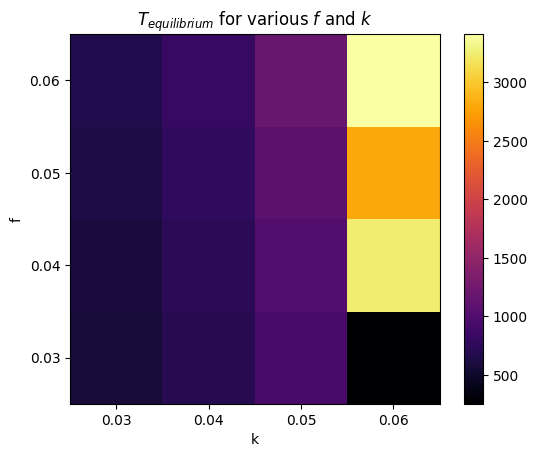

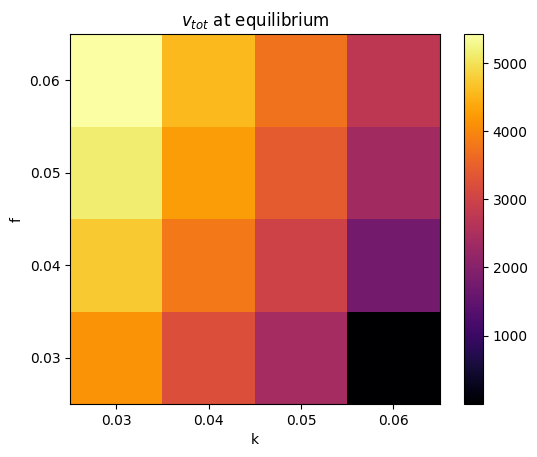

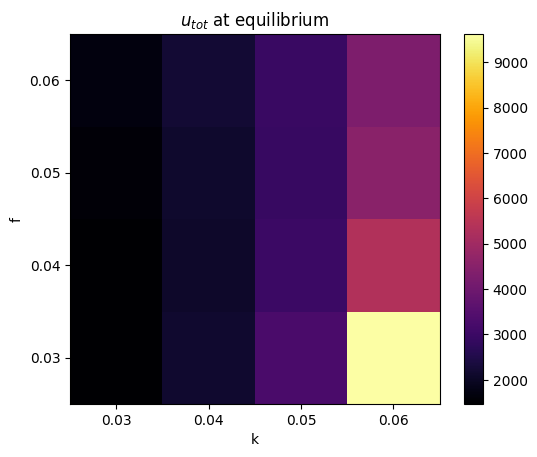

254.0


In [112]:
# print(tot_v_dict.keys())
# print(tot_u_dict.keys())


# print(tot_v_dict[f'v(f={f_list[0]},k={k_list[0]})'])

stopping_criterion = 10**-5

v_equilibria = np.zeros((len(f_list), len(k_list)))
tot_v_equilibria = np.zeros((len(f_list), len(k_list)))
tot_u_equilibria = np.zeros((len(f_list), len(k_list)))
for j, f_value in enumerate(f_list):
        for k, k_value in enumerate(k_list):
            tot_v_list = tot_v_dict[f'v(f={f_value},k={k_value})']
            tot_u_list = tot_u_dict[f'u(f={f_value},k={k_value})']
            previous_tot_v = 10000
            for t, tot_v in enumerate(tot_v_list):
                if abs(tot_v - previous_tot_v)/previous_tot_v < stopping_criterion or tot_v < stopping_criterion or tot_u_list[t] < stopping_criterion:
                    tot_v_equilibrium = tot_v
                    v_equilibria[j, k] = t
                    tot_v_equilibria[j, k] = tot_v_equilibrium
                    tot_u_equilibrium = tot_u_list[t]
                    tot_u_equilibria[j, k] = tot_u_equilibrium

                    if abs(tot_u_equilibrium - tot_v_equilibrium)/tot_v_equilibrium < 0.05:
                        print(f'We have an equilibrium for (f,k) = ({f_value},{k_value}), with conc = {tot_v_equilibrium} at t = {t}')

                    break
                else:
                    previous_tot_v = tot_v

print(v_equilibria)
# print(tot_v_dict['v(f=0.05,k=0.06)'])

# Plot the binary mask with the correct color mapping
plt.title(r'$T_{equilibrium}$ for various $f$ and $k$')
plt.imshow(v_equilibria, cmap='inferno', interpolation='nearest', origin='lower')
plt.colorbar()
# plt.clim(0, int(math.ceil(np.max(tot_concentrations)/ 100.0)) * 100)
plt.xticks(np.arange(len(k_list)), k_list)
plt.yticks(np.arange(len(f_list)), f_list)
plt.xlabel('k')
plt.ylabel('f')
plt.savefig(f'downloads/f_k_tile_equilibria.png',dpi=300)
plt.show()


# Plot the binary mask with the correct color mapping
plt.title(r'$v_{tot}$ at equilibrium')
plt.imshow(tot_v_equilibria, cmap='inferno', interpolation='nearest', origin='lower')
plt.colorbar()
# plt.clim(0, int(math.ceil(np.max(tot_concentrations)/ 100.0)) * 100)
plt.xticks(np.arange(len(k_list)), k_list)
plt.yticks(np.arange(len(f_list)), f_list)
plt.xlabel('k')
plt.ylabel('f')
plt.savefig(f'downloads/f_k_tile_v_t_equilibrium.png',dpi=300)
plt.show()       
            

# Plot the binary mask with the correct color mapping
plt.title(r'$u_{tot}$ at equilibrium')
plt.imshow(tot_u_equilibria, cmap='inferno', interpolation='nearest', origin='lower')
plt.colorbar()
# plt.clim(0, int(math.ceil(np.max(tot_concentrations)/ 100.0)) * 100)
plt.xticks(np.arange(len(k_list)), k_list)
plt.yticks(np.arange(len(f_list)), f_list)
plt.xlabel('k')
plt.ylabel('f')
plt.savefig(f'downloads/f_k_tile_u_t_equilibrium.png',dpi=300)
plt.show()       


# print(tot_v_dict['v(f=0.03,k=0.06)'])

for j, f_value in enumerate(f_list):
        for k, k_value in enumerate(k_list):
            if f_value == 0.03 and k_value == 0.06:
                t_u_eq = v_equilibria[j,k]
                print(t_u_eq)

